### Radiation diagnostic

In [1]:
%time

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 4.29 µs


In [41]:
%pwd

'/home/b/b382257/wp7/AQUA/diagnostics/radiation/notebooks'

In [24]:
#home/b/b382257/wp7/AQUA/aqua/reader/reader.py
from aqua import Reader, catalogue, inspect_catalogue
import sys
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import calendar # convert month numbers into month name strings with calendar.month_name[1] => 'January'
# all-caps month abbr: calendar.month_abbr[1].upper() => 'JAN'
from cdo import *
import dask.array as da
import dask.distributed as dd
# Dask: parallel computing with Python
from dask.distributed import Client
import dask
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
%env PATH={os.environ["PATH"]}:{sys.exec_prefix}/bin/

env: PATH=/sw/spack-levante/texlive-live2021-l5o6sw/bin/x86_64-linux:/sw/spack-levante/texlive-live2021-l5o6sw/bin:/sw/spack-levante/git-lfs-2.11.0-oihcwo/bin:/sw/spack-levante/git-2.31.1-25ve7r/bin:/sw/spack-levante/jupyterhub/jupyterhub/bin:/sw/spack-workplace/spack/bin:/usr/share/Modules/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/home/b/b382257/.conda/envs/aqua/bin/:/home/b/b382257/.conda/envs/aqua/bin/


In [3]:
plotdir = './plots/RadiationTOA/'
if not os.path.exists(plotdir):
    os.makedirs(plotdir)

In [4]:
label_tco1279 = '9km'
label_tco2559 = ' tco2559 4.5km'
label_tco3999 = '2.8km'
label_tco399  = 'tco399'
label_icon = 'icon 5km'
label_era5 = 'ERA5'

In [5]:
cdo = Cdo()

In [6]:
cat = catalogue()
inspect_catalogue(cat)

IFS	tco3999-ng5	2.8km experiment, coupled with FESOM
	- ICMGG_atm2d	original 2d output
	- ICMU_atm2d	original 2d output (lnsp)
	- ICMU_atm3d	original 3d output
	- interpolated_global	NN interpolation to 5400x2700 grid (lon=[-180,180], lat=[-90, 90])
	- lra-r100-monthly	LRA data monthly at r100
IFS	tco2559-ng5	4km experiment, coupled with FESOM
	- ICMGG_atm2d	original 2d output
	- ICMU_atm2d	original 2d output (lnsp)
	- ICMU_atm3d	original 3d output
	- interpolated_global	NN interpolation to 5400x2700 grid (lon=[-180,180], lat=[-90, 90])
	- lra-r100-monthly	LRA data monthly at r100
IFS	tco1279-orca025	9km baseline, coupled to NEMO, deep conv ON
	- ICMGG_atm2d	original 2d output
	- ICMU_atm2d	original 2d output (lnsp)
	- ICMU_atm3d	original 3d output
	- lra-r100-monthly	LRA data monthly at r100
IFS	test-tco2559	4km experiment, coupled with FESOM
	- ICMGG_atm2d	2d output
	- ICMU_atm3d	3d output
IFS	test-tco79	TCO79 test data
	- short	original 2d output
	- long	coarse IFS data 1y
IFS	tco25

['IFS',
 'FESOM',
 'ICON',
 'MSWEP',
 'ERA5',
 'CERES',
 'AVISO',
 'PHC3',
 'WOA18',
 'OSI-SAF']

In [7]:
#inspect_catalogue(cat, model = 'CERES', exp = 'ebaf-toa41')

In [8]:
reader_tco2559 = Reader(model = 'IFS', exp = 'tco2559-ng5', source = 'lra-r100-monthly')
data_tco2559 = reader_tco2559.retrieve(fix=False)

In [9]:
reader_icon = Reader(model = 'ICON', exp = 'ngc2009', source = 'lra-r100-monthly')
data_icon = reader_icon.retrieve()

In [10]:
reader_CERES = Reader(model='CERES', exp = 'ebaf-toa41', source = 'monthly')
ceres = reader_CERES.retrieve()

In [11]:
reader_era5 = Reader(model="ERA5", exp="era5", source="monthly")
data_era5 = reader_era5.retrieve(fix=True)

### CERES

In [12]:
temporal_mean_net = ceres['toa_net_all_mon'].sel(time=ceres.time).mean(dim='time')
global_mean_net = reader_CERES.fldmean(temporal_mean_net).compute()

temporal_mean_sw = ceres['toa_sw_all_mon'].sel(time=ceres.time).mean(dim='time')
global_mean_sw = reader_CERES.fldmean(temporal_mean_sw).compute()

temporal_mean_lw = ceres['toa_lw_all_mon'].sel(time=ceres.time).mean(dim='time')
global_mean_lw = reader_CERES.fldmean(temporal_mean_lw).compute()

temporal_mean_sw_clr = ceres['toa_sw_clr_c_mon'].sel(time=ceres.time).mean(dim='time')
global_mean_sw_clr = reader_CERES.fldmean(temporal_mean_sw_clr).compute()

temporal_mean_solar_mon = ceres['solar_mon'].sel(time=ceres.time).mean(dim='time')
global_mean_solar_mon = reader_CERES.fldmean(temporal_mean_solar_mon).compute()

sw_ceres_new = global_mean_solar_mon - global_mean_sw 


In [13]:
ceres_imbalance = sw_ceres_new - global_mean_lw

### tco 2559

In [14]:
tco2559_temporal_mean_lw = data_tco2559['mtntrf'].sel(time=data_tco2559.time).mean(dim='time')
tco2559_global_mean_lw = reader_tco2559.fldmean(tco2559_temporal_mean_lw).compute()

tco2559_temporal_mean_sw = data_tco2559['mtnsrf'].sel(time=data_tco2559.time).mean(dim='time')
tco2559_global_mean_sw = reader_tco2559.fldmean(tco2559_temporal_mean_sw).compute()

tco2559_imbalance = tco2559_global_mean_lw + tco2559_global_mean_sw

### ICON 

In [40]:
icon_temporal_mean_lw = data_icon['mtntrf'].sel(time=data_icon.time).mean(dim='time')

# Compute global mean for longwave radiation
weights = np.cos(np.deg2rad(data_icon.lat))
weights.name = "weights"
icon_weighted_lw = icon_temporal_mean_lw.weighted(weights)
icon_global_mean_lw = icon_weighted_lw.mean(('lon', 'lat'))

icon_temporal_mean_sw = data_icon['mtnsrf'].sel(time=data_icon.time).mean(dim='time')

# Compute global mean for shortwave radiation
weights = np.cos(np.deg2rad(data_icon.lat))
weights.name = "weights"
icon_weighted_sw = icon_temporal_mean_sw.weighted(weights)
icon_global_mean_sw = icon_weighted_sw.mean(('lon', 'lat'))

icon_imbalance = icon_global_mean_lw + icon_global_mean_sw

# Compute global mean for imbalance
icon_global_mean_sw = icon_global_mean_sw.mean().compute()[()]
icon_global_mean_lw = icon_global_mean_lw.mean().compute()[()]
icon_global_mean_imbalance = icon_imbalance.mean().compute()[()]

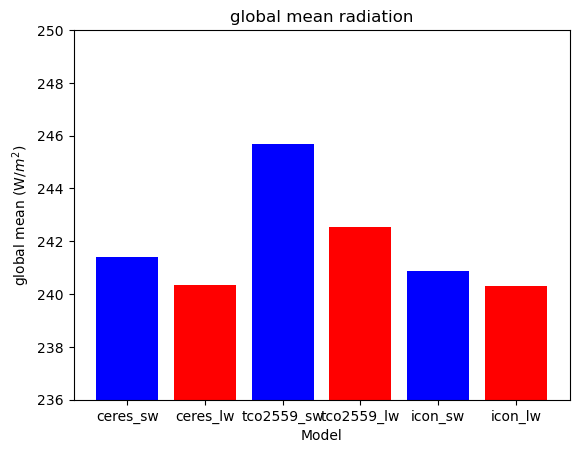

In [19]:
model_names = ['ceres_sw', 'ceres_lw','tco2559_sw', 'tco2559_lw', 'icon_sw', 'icon_lw']
global_means = [sw_ceres_new, global_mean_lw, tco2559_global_mean_sw, -tco2559_global_mean_lw, icon_global_mean_sw, -icon_global_mean_lw]
plt.bar(model_names, global_means, color = ['blue','red'])

plt.xlabel('Model')
plt.ylabel('global mean (W/$m^2$)')
plt.ylim(236, 250)
plt.title('global mean radiation')
plt.savefig(plotdir+'CompareModels_RadiationTOA.png',dpi=300, facecolor='white')
plt.show()

In [21]:
# Preparing the one year data of each monthly data set
# icon

icon_data_2020_lw = data_icon.mtntrf.sel(time=slice('2020-01-01', '2020-12-31'))
# Compute global mean for longwave radiation
weights = np.cos(np.deg2rad(data_icon.lat))
icon_weighted_lw_2020 = icon_data_2020_lw.weighted(weights)
icon_global_mean_lw_2020 = icon_weighted_lw_2020.mean(('lon', 'lat'))

icon_data_2020_sw = data_icon.mtnsrf.sel(time=slice('2020-01-01', '2020-12-31'))
# Compute global mean for shotwave radiation
weights = np.cos(np.deg2rad(data_icon.lat))
icon_weighted_sw_2020 = icon_data_2020_sw.weighted(weights)
icon_global_mean_sw_2020 = icon_weighted_sw_2020.mean(('lon', 'lat'))

icon_net_2020 = icon_global_mean_lw_2020 + icon_global_mean_sw_2020

#--------------------------------------------------------------------------

# tco2559
tco2559_data_2020_lw = data_tco2559.mtntrf.sel(time=slice('2020-01-01', '2020-12-31'))
# Compute global mean for longwave radiation
weights = np.cos(np.deg2rad(data_tco2559.lat))
tco2559_weighted_lw_2020 = tco2559_data_2020_lw.weighted(weights)
tco2559_global_mean_lw_2020 = tco2559_weighted_lw_2020.mean(('lon', 'lat'))


tco2559_data_2020_sw = data_tco2559.mtnsrf.sel(time=slice('2020-01-01', '2020-12-31'))
# Compute global mean for shortwave radiation
weights = np.cos(np.deg2rad(data_tco2559.lat))
tco2559_weighted_sw_2020 = tco2559_data_2020_sw.weighted(weights)
tco2559_global_mean_sw_2020 = tco2559_weighted_sw_2020.mean(('lon', 'lat'))

tco2559_net_2020 = tco2559_global_mean_lw_2020 + tco2559_global_mean_sw_2020
#--------------------------------------------------------------------------
# ceres
ceres_data_2020_lw = -ceres['toa_lw_all_mon'].sel(time=slice('2020-01-01', '2020-12-31'))
# Compute global mean for longwave radiation
weights = np.cos(np.deg2rad(ceres.lat))
ceres_weighted_lw_2020 = ceres_data_2020_lw.weighted(weights)
ceres_global_mean_lw_2020 = ceres_weighted_lw_2020.mean(('lon', 'lat'))

ceres_data_2020_net = ceres['toa_net_all_mon'].sel(time=slice('2020-01-01', '2020-12-31'))
# Compute global mean for net radiation
weights = np.cos(np.deg2rad(ceres.lat))
ceres_weighted_net_2020 = ceres_data_2020_net.weighted(weights)
ceres_global_mean_net_2020 = ceres_weighted_net_2020.mean(('lon', 'lat'))

ceres_data_2020_sw1 = ceres['solar_mon'].sel(time=slice('2020-01-01', '2020-12-31'))
# Compute global mean for longwave radiation
weights = np.cos(np.deg2rad(ceres.lat))
ceres_weighted_sw1_2020 = ceres_data_2020_sw1.weighted(weights)
ceres_global_mean_sw1_2020 = ceres_weighted_sw1_2020.mean(('lon', 'lat'))

ceres_data_2020_sw2 = ceres['toa_sw_all_mon'].sel(time=slice('2020-01-01', '2020-12-31'))
# Compute global mean for longwave radiation
weights = np.cos(np.deg2rad(ceres.lat))
ceres_weighted_sw2_2020 = ceres_data_2020_sw2.weighted(weights)
ceres_global_mean_sw2_2020 = ceres_weighted_sw2_2020.mean(('lon', 'lat'))

ceres_global_mean_sw_2020 = ceres_global_mean_sw1_2020 - ceres_global_mean_sw2_2020

In [22]:
# now we need some data to show the error/uncertrainty of the models. For this, we calculate the mean of each month for the observation in the time range from 2020-2022. 
# Calculate monthly SW radiation
ceres_sw = ceres['solar_mon']
ceres_sw1 = ceres_sw.sel(time=slice('2000-01-01', '2020-12-31'))
ceres_sw2 = ceres['toa_sw_all_mon'].sel(time=slice('2000-01-01', '2020-12-31'))
ceres_monthly_sw = ceres_sw1 - ceres_sw2

# Calculate monthly LW radiation
ceres_lw = -ceres['toa_lw_all_mon'].sel(time=slice('2000-01-01', '2020-12-31'))

# Calculate monthly net radiation
ceres_net = ceres['toa_net_all_mon'].sel(time=slice('2000-01-01', '2020-12-31'))

# Compute global mean for each radiation variable
weights = np.cos(np.deg2rad(ceres.lat))
ceres_weighted_sw = ceres_monthly_sw.weighted(weights)
ceres_global_mean_sw = ceres_weighted_sw.mean(('lon', 'lat'))

ceres_weighted_lw = ceres_lw.weighted(weights)
ceres_global_mean_lw = ceres_weighted_lw.mean(('lon', 'lat'))

ceres_weighted_net = ceres_net.weighted(weights)
ceres_global_mean_net = ceres_weighted_net.mean(('lon', 'lat'))

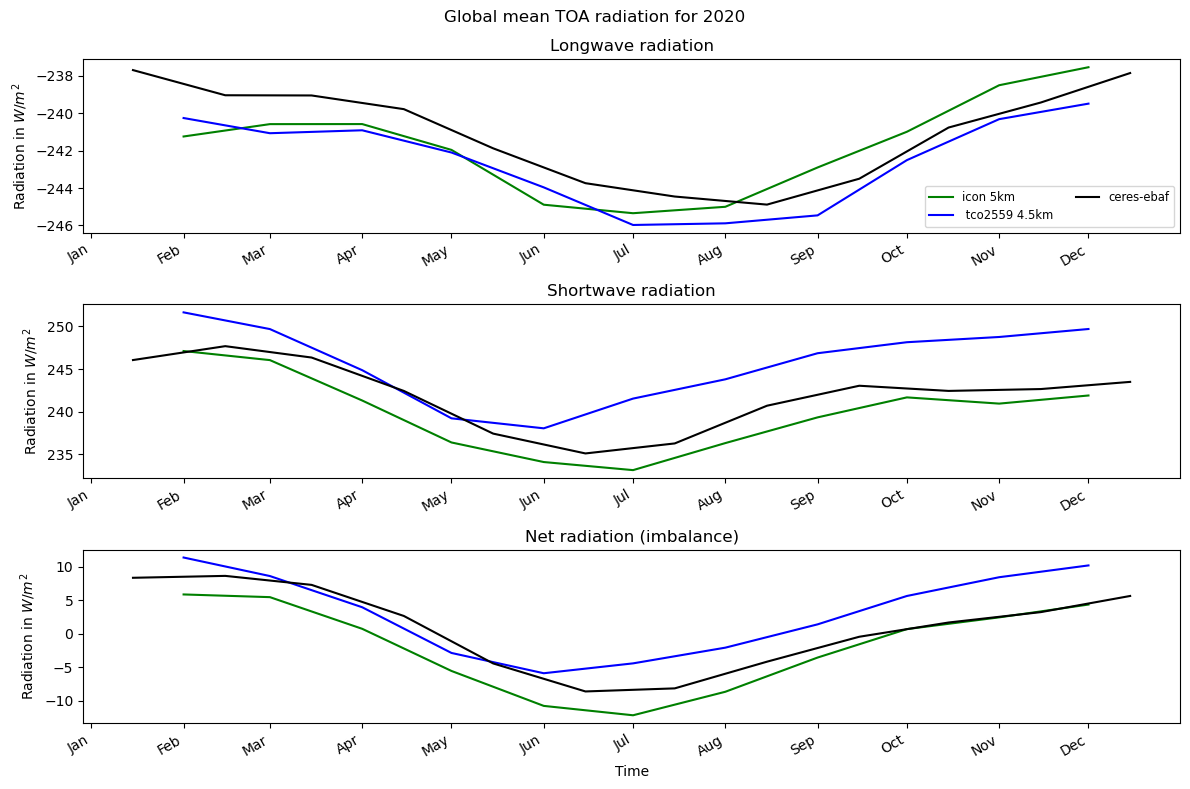

In [25]:
fig, axes = plt.subplots(3, 1,figsize=(12,8))

# ------------------------ panel LW------------------------
icon_global_mean_lw_2020.plot(ax=axes[0],color='green',label=label_icon,x='time')
tco2559_global_mean_lw_2020.plot(ax=axes[0],color='blue',label=label_tco2559,x='time')
ceres_global_mean_lw_2020.plot(ax=axes[0],color='black',label='ceres-ebaf',x='time')
#months_sw = [calendar.month_abbr[i] for i in ceres_monthly_sw.month]

axes[0].set_ylabel('Radiation in $W/m^2$')
axes[0].set_ylabel('Radiation in $W/m^2$')
axes[0].set_title('Longwave radiation')
axes[0].set_xticklabels([])
axes[0].set_xlabel('')

for ax in axes:
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
axes[0].legend(loc="lower right",frameon=True,fontsize='small',ncol=2)

# # ------------------------ panel SW ------------------------
icon_global_mean_sw_2020.plot(ax=axes[1],color='green',label=label_icon,x='time')
tco2559_global_mean_sw_2020.plot(ax=axes[1],color='blue',label=label_tco2559,x='time')
ceres_global_mean_sw_2020.plot(ax=axes[1],color='black',label='ceres-ebaf',x='time')

# Plot individual years

axes[1].set_ylabel('Radiation in $W/m^2$')
axes[1].set_title('Shortwave radiation')
axes[1].set_xticklabels([])
axes[1].set_xlabel('')

for ax in axes:
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# # ------------------------ panel Net ------------------------
icon_net_2020.plot(ax=axes[2],color='green',label=label_icon,x='time')
tco2559_net_2020.plot(ax=axes[2],color='blue',label=label_tco2559,x='time')
ceres_global_mean_net_2020.plot(ax=axes[2],color='black',label='ceres-ebaf',x='time')


axes[2].set_ylabel('Radiation in $W/m^2$')
axes[2].set_title('Net radiation (imbalance)')
#axes[2].set_xlim(['2020-01-01','2021-12-31'])


plt.suptitle('Global mean TOA radiation for 2020')
plt.tight_layout()
plt.savefig(plotdir+'LinePlot_RadiationTOA.png',dpi=300, facecolor='white')

### Monthly bias maps for tco2559 with respect to ceres

In [ ]:
def compare_datasets(dataset1, dataset2, var1_name, var2_name, time_range, statistic):
    # Select the desired variable from both datasets
    var1 = dataset1[var1_name]
    var2 = dataset2[var2_name]
    
    # Select the desired time range
    var1 = var1.sel(time=time_range)
    var2 = var2.sel(time=time_range)
    
    # Calculate the bias between the datasets
    if statistic == 'mean':
        result = var2.mean(dim='time') - var1.mean(dim='time')
    elif statistic == 'max':
        result = var2.max(dim='time') - var1.max(dim='time')
    elif statistic == 'min':
        result = var2.min(dim='time') - var1.min(dim='time')
    elif statistic == 'diff':
        result = var2 - var1
    elif statistic == 'std':
        result = var2.std(dim='time') - var1.std(dim='time')
    else:
        raise ValueError("Invalid statistic. Please choose one of 'mean', 'std', 'max', 'min', or 'diff'.")
    
    # Plot the bias map
    fig, ax = plt.subplots(figsize=(7, 5))
    cnplot = result.plot(ax=ax, cmap='RdBu_r', vmin=-10, vmax=10)
    ax.set_title(f'Bias of {var2_name} ({dataset2[var2_name].long_name}) [{var2.units}] ({statistic})\n Experiment with respect to CERES EBAF TOA41')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    fig.colorbar(cnplot, ax=ax, label=f'{var2.units}')
    plt.tight_layout()
    
    # Save the figure as a PNG file
    plt.savefig(plotdir + 'bias_map.png', dpi=300, facecolor='white')
    
    return result, ax


Quick plot

In [ ]:
ceres['toa_lw_all_mon']
data_tco2559['mtntrf'][1,:,:].plot()

### Gregory Plot

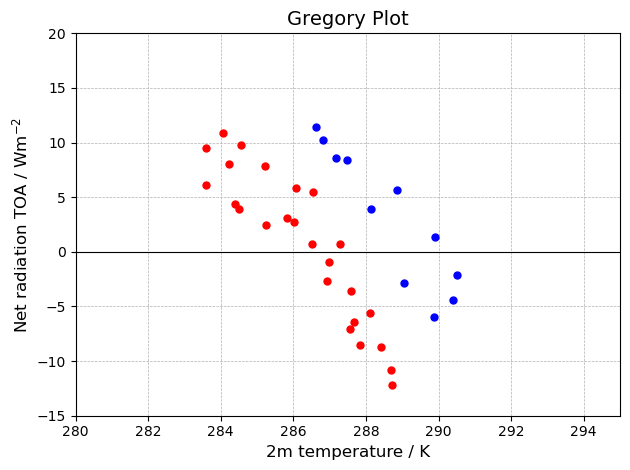

In [39]:
fig, ax = plt.subplots()

# Plot the data for IFS tco2559
ax.axhline(0, color="k", lw=0.8)
ax.plot(
    reader_tco2559.fldmean(data_tco2559["2t"].resample(time="M").mean()) ,
    reader_tco2559.fldmean((data_tco2559["mtnsrf"] + data_tco2559["mtntrf"]).resample(time="M").mean()),
    marker="o",
    color="b",  
    linestyle=" ",  
    markersize=5,  
    label = label_tco2559,
)
# Plot the data for model icon
ax.plot(
    reader_icon.fldmean(data_icon["2t"].resample(time="M").mean()),
    reader_icon.fldmean((data_icon["mtnsrf"] + data_icon["mtntrf"]).resample(time="M").mean()),
    marker="o",
    color="r",
    linestyle=" ",
    markersize=5,
    label=label_icon,  # Add a label for the legend
)
# Plot the data for ERA5 (2000-2020)
era5_2t_2000_2020 = data_era5["T2M"].sel(time=slice('2000-01-01', '2020-12-31'))
era5_2t_2000_2020_resampled = era5_2t_2000_2020.resample(time="M").mean()
era5_tsr_2000_2020 = data_era5["TSR"].sel(time=slice('2000-01-01', '2020-12-31'))
era5_tsr_2000_2020_resampled = era5_tsr_2000_2020.resample(time="M").mean()
era5_ttr_2000_2020 = data_era5["TTR"].sel(time=slice('2000-01-01', '2020-12-31'))
era5_ttr_2000_2020_resampled = era5_ttr_2000_2020.resample(time="M").mean()

ax.plot(
    reader_era5.fldmean(era5_2t_2000_2020_resampled),
    reader_era5.fldmean(era5_tsr_2000_2020_resampled) + reader_era5.fldmean(era5_ttr_2000_2020_resampled) ,
    marker="o",
    color="g",
    linestyle=" ",
    markersize=5,
    label=label_era5  
)

# Set labels and title
ax.set_xlabel("2m temperature / K", fontsize=12)  
ax.set_ylabel(r"Net radiation TOA / $\rm Wm^{-2}$", fontsize=12) 
ax.set_title("Gregory Plot", fontsize=14) 

# Set tick parameters
ax.tick_params(axis="both", which="major", labelsize=10)  


ax.grid(True, linestyle="--", linewidth=0.5) 
ax.set_xlim(280, 295)  
ax.set_ylim(-15, 20) 


fig.tight_layout()
plt.savefig("./plots/RadiationTOA/gregory_plot.png", dpi=300)
plt.show()
